<p style="font-size:30px; text-align:center"><b>Black-Scholes Basics</b></p>
We review the Black-Scholes model with continuous dividends. The results are presented using the Python data science stack.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mtick
import ipywidgets as wd
from mpl_toolkits import mplot3d

import sys
sys.path.append("../../")
import pyqfin.models.black_scholes as bs

# Dynamics of the Underlying

**Definition**: The *Black-Scholes model* is defined by a stochastic process
\begin{align}
        dS_t = (r-q) S_t dt + \sigma S_t dW_t, && S_0 = s_0
\end{align}
on a probability space $(\Omega, \mathcal{F}, \mathbb{Q})$, where we think of $\mathbb{Q}$ as the risk-neutral measure with respect to a *bank account numeraire* $B(t)$ defined by
\begin{align*}
    dB_t = r B_t dt, && B_0=1
\end{align*}
Here,
* $s_0$ is the initial value for the stock
* $r \in \mathbb{R}$ is a fixed *risk-free rate*, 
* $\sigma > 0$ is the *volatility*, 
* $W_t$ is a Brownian motion,
* $S_t$ is the evolution of the stock price.


**Lemma (explicit evolution of the underlying):** In the Black-Scholes model, the stock price $S$ and the bank account numeraire $B$ have the explicit solution 
\begin{align}
    S_t & = s_0 \exp(((r-q - \tfrac{1}{2} \sigma^2)t + \sigma W_t) \\
    B_t & = \exp(rt)
\end{align}

**Proof:** This follows from the Ito Lemma applied to the function $f(x)=\ln(x)$:
\begin{align*}
    d(\ln(S_t))
    &= \frac{1}{S_t} dS_t - \frac{1}{2 S_t^2} dS_t^2
    = \frac{1}{S_t} ((r-q)S_t dt + \sigma S_t dW_t) - \frac{1}{2 S_t^2} (\sigma^2 S_t^2)dt
    = (r-q) dt + \sigma dW_t - \frac{1}{2} \sigma^2 dt
\end{align*}
and thus
\begin{align*}
    \ln(S_t) = \ln(S_0) + \int_0^t{r-q-\tfrac{1}{2} \sigma^2 du} + \int_0^t{\sigma dW_u}
    =\ln(S_0) + (r-q-\tfrac{1}{2} \sigma^2)t + \sigma W_t,
\end{align*}
which yields the result by applying $\exp$.

**Corollary (distributions):** The stock price $S_t$ is log-normally distributed and for any $0 \leq t \leq T$
\begin{align*}
    \mathbb{E}[ S_T \mid \mathcal{F}_t] &= S_t e^{(r-q)(T-t)}\\
    \mathbb{V}[S_T \mid \mathcal{F}_t] &= S_t^2 (e^{\sigma^2(T-t)}-1) e^{2(r-q-\tfrac{1}{2}\sigma^2)(T-t) + \sigma^2(T-t)}\\
    \operatorname{Cov}[S_t, S_T] &= s_0^2 e^{\sigma^2 \tfrac{t+T}{2}} ( e^{\sigma^2 t} - 1 )  e^{(r-q - \tfrac{1}{2}\sigma^2) (t+T)}
\end{align*}

**Proof:** Clearly,
\begin{align*}
    (r-q - \tfrac{1}{2} \sigma^2)t + \sigma W_t \sim \mathcal{N}((r-q - \tfrac{1}{2} \sigma^2)t, \sigma^2 t),
\end{align*}
thus $S_t$ is log-normally distributed by the explicit solution formula. This implies the result for the mean and the variance. For the auto-covariance, we use the below Lemma to calculate
\begin{align*}
    \mathbb{E}[\exp(\sigma W_t) \exp(\sigma W_T)]
    &= \exp(\tfrac{1}{2}\sigma^2 T) \mathbb{E}[\exp(\sigma W_t) \exp(\sigma W_T - \tfrac{1}{2}\sigma^2 T)] \\
    &= \exp(\tfrac{1}{2}\sigma^2 T)\mathbb{E}[\mathbb{E}[\exp(\sigma W_t) \exp(W_T - \tfrac{1}{2}\sigma^2 T) \mid \mathcal{F}_t]] \\
    &= \exp(\tfrac{1}{2}\sigma^2 T)\mathbb{E}[\exp(\sigma W_t) \mathbb{E}[\exp(\sigma W_T - \tfrac{1}{2}\sigma^2 T)  \mid \mathcal{F}_t]] \\
    &= \exp(\tfrac{1}{2}\sigma^2 T) \mathbb{E}[\exp(\sigma W_t)\exp(\sigma W_t - \tfrac{1}{2}t \sigma^2)] \\
    &= \exp(\tfrac{1}{2}\sigma^2 (T+3t)) \mathbb{E}[\exp(2\sigma W_t - \tfrac{1}{2} (2 \sigma)^2 t)] \\
    &= \exp(\tfrac{1}{2}\sigma^2 (T+3t))
\end{align*}
Again, using the below lemma, we obtain
\begin{align*}
    \mathbb{E}[\exp(\sigma W_t)]\mathbb{E}[\exp(\sigma W_T)]
    =\exp(\tfrac{1}{2}\sigma^2(T+t))\mathbb{E}[\exp(\sigma W_t-\tfrac{1}{2} \sigma^2 t)]\mathbb{E}[\exp(\sigma W_T-\tfrac{1}{2}\sigma^2 W_T)]
    =\exp(\tfrac{1}{2}\sigma^2(T+t)).
\end{align*}
In total, this results in
\begin{align*}
    \operatorname{Cov}[S_t, S_T] 
    &=\operatorname{Cov}[s_0 \exp(((r-q - \tfrac{1}{2} \sigma^2)t + \sigma W_t),s_0 \exp(((r-q - \tfrac{1}{2} \sigma^2)T + \sigma W_T)] \\
    &=s_0^2 \exp((r-q - \tfrac{1}{2} \sigma^2)(t+T)\operatorname{Cov}[ \exp(\sigma W_t), \exp(\sigma W_T)] \\
    &=s_0^2 \exp((r-q - \tfrac{1}{2} \sigma^2)(t+T)(\exp(\tfrac{1}{2}\sigma^2 (T+3t)) - \exp(\tfrac{1}{2}\sigma^2(T+t)))\\
    &=s_0^2 \exp((r-q - \tfrac{1}{2} \sigma^2)(t+T)\exp(\tfrac{1}{2}\sigma^2(T+t))(\exp(\sigma^2 t) - 1)
\end{align*}

**Lemma:** Let $W_t$ be a Brownian motion. For any $c \in \mathbb{R}$, the procress $X_t := \exp(cW_t - \tfrac{1}{2}c^2 t)$ is a martingale.

**Proof:** This follows simply from Itos Lemma on $f(x,t) := \exp(c x - \tfrac{1}{2} c^2 t)$
\begin{align*}
    dX_t
    = d(f(W_t,t))
    = \partial_x f(W_t,t)dW_t + \partial_t f(W_t,t)dt + \tfrac{1}{2} \partial_x^2 f(W_t,t)dt
    = cX_t dW_t - \tfrac{1}{2}c^2 X_t dt + \tfrac{1}{2} c^2 X_t dt
    =cX_t dW_t,
\end{align*}
which has zero drift.

# Simulation

Given that the conditional distributions of $S_t$ can be worked out analytically, the process can be simulated on any time grid $0=t_0 < \ldots < t_M$ with spacing $\delta _i := t_{i+1} - t_i$, by creating $M-1$ independent standard normal random variables $Z_i$ and then setting
\begin{align*}
    S_{t_i} = s_0 \prod_{j=0}^{i-1}{e^{(r-q-\tfrac{1}{2}\sigma^2) \delta_j + \sigma \sqrt{\delta_j} Z_j}}
\end{align*}
The resulting realizations $S_{t_0}, \ldots, S_{t_M}$ have a joint distribution that converges to the analytical distribution.

In [3]:
params = bs.Params(sigma=0.2, r=0.03, q=0.01)

ntimes = 10
time_grid = np.linspace(0, 2, ntimes)
npaths = 100000

bsm = bs.Simulation(params, time_grid, npaths)
bsm.simulate(s0=100)

## Example Paths

<IPython.core.display.Javascript object>


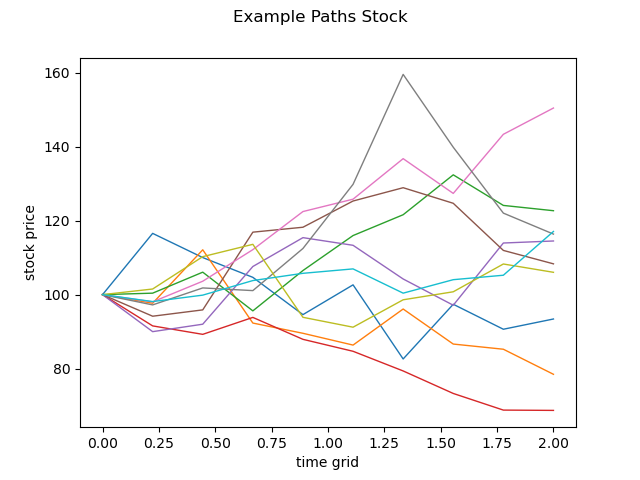

In [4]:
figpath, axpath = plt.subplots()
figpath.suptitle('Example Paths Stock')
axpath.plot(time_grid, bsm.s_[:10, :].T, lw=1)
axpath.set_xlabel('time grid')
axpath.set_ylabel('stock price')
plt.show()

## Stock Price Mean

<IPython.core.display.Javascript object>


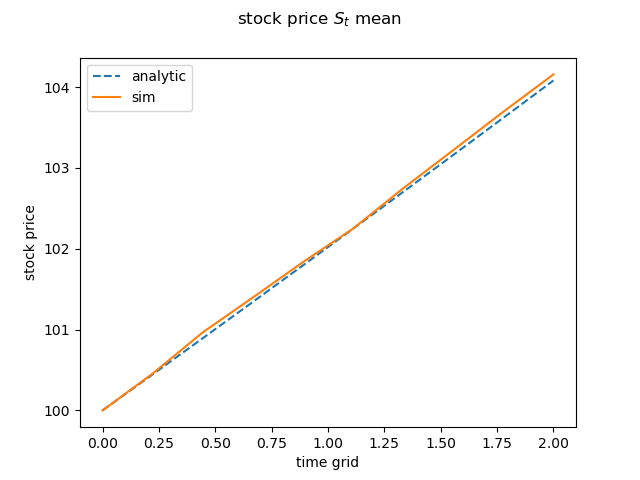

In [5]:
figmean, axmean = plt.subplots()
figmean.suptitle('stock price $S_t$ mean')
axmean.plot(time_grid, bsm.stock_means(), label='analytic', linestyle='--')
axmean.plot(time_grid, bsm.s_.mean(axis=0), label='sim')
axmean.set_xlabel('time grid')
axmean.set_ylabel('stock price')
axmean.legend()
plt.show()

## Stock Price Standard Deviation

<IPython.core.display.Javascript object>


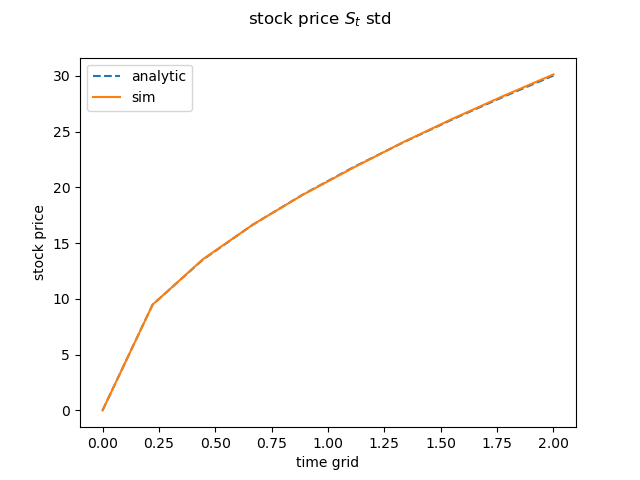

In [6]:
figvar, axvar = plt.subplots()
figvar.suptitle('stock price $S_t$ std')
axvar.plot(time_grid, np.sqrt(bsm.stock_vars()), label='analytic', linestyle='--')
axvar.plot(time_grid, bsm.s_.std(axis=0), label='sim')
axvar.set_xlabel('time grid')
axvar.set_ylabel('stock price')
axvar.legend()
plt.show()

## Stock Price Autocovariance

<IPython.core.display.Javascript object>


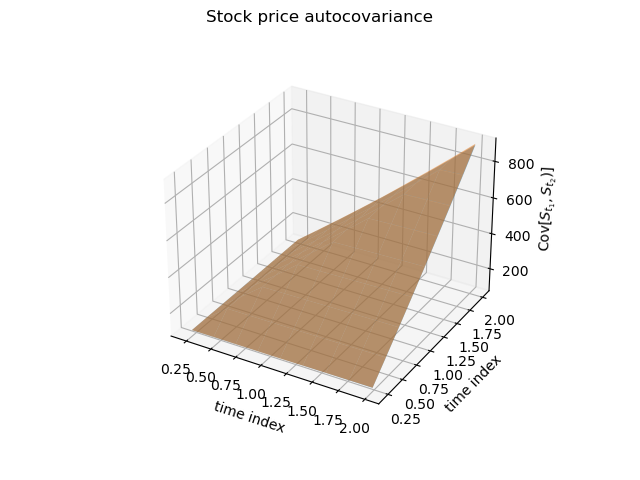

In [7]:
tx, ty = np.meshgrid(bsm.time_grid[1:], bsm.time_grid[1:])
figxcov = plt.figure()
figxcov.suptitle('Stock price autocovariance')
axxcov = plt.axes(projection="3d")
axxcov.plot_surface(tx, ty, bsm.stock_autocovs()[1:,1:], label='analytic', alpha=0.5)
axxcov.plot_surface(tx, ty, np.cov(bsm.s_[:,1:].T), label='sim', alpha=0.5)
axxcov.set_xlabel('time index')
axxcov.set_ylabel('time index')
axxcov.set_zlabel('$\operatorname{Cov}[S_{t_1}, S_{t_2})]$')
plt.show()

# Option Pricing & Black-Scholes Formula

**Theorem (risk-neutral pricing):** Let $V_T$ be an $\mathcal{F}_T$-measurable payoff. Then the arbitrage-free price $V_t$ of $V_T$ at $t$ is given by
\begin{align*}
    V_t = e^{-r(T-t)}\mathbb{E}[V_T \mid \mathcal{F}_t].
\end{align*}

**Definition:** For any *strike* $K$ and *maturity* $T$, the payoffs
\begin{align*}
    C(T) &:= (S_T - K)^+, \\
    P(T) &:= (K-S_T)^+, \\
    F(T) &:= S_T - K
\end{align*}
are called *European call option*, *European put option* and *forward*.

A key feature of the Black-Scholes model is that the prices of options can be calculated analytically.

**Theorem (Black-Scholes formula)**: The price of a European call option $C$, put option $P$ and Forward $F$ with maturity $T$ and strike $K$ is given by
\begin{align*}
    C_t &= e^{-r (T-t)}( f_t \Phi(d_1) - K \Phi(d_2)),\\
    P_t &= e^{-r(T-t)}(K \Phi(-d_2) - f_t \Phi(-d_1)), \\
    F_t &= e^{-q (T-t)}S_0 - e^{-r(T-t)} K, \\
    d_1 &:= \frac{1}{\sigma \sqrt{T-t}} \Big( (r-q+\tfrac{1}{2}\sigma^2)(T-t) + \ln\Big(\frac{S_0}{K}\Big) \Big)\\
    d_2 &:= d_1 - \sigma \sqrt{T-t},\\
    f_t &:= e^{(r-q)(T-t)}S_t
\end{align*}
and the put/call parity 
\begin{align*}
    C_t - P_t = e^{-q (T-t)}S_t - e^{-r(T-t)} K
\end{align*}
holds. Here $\Phi$ denotes the CDF of the standard normal distribution.

**Proof:** Without loss of generality, we assume $t=0$.  By risk-neutral pricing, we have
\begin{align*}
    C_0 = e^{-rT} \mathbb{E}[C_T] = e^{-rT} \mathbb{E}[1_{S_T > K}(S_T - K)].
\end{align*}
By the explicit representation of $S_T$, we have
\begin{align*}
    S_T = s_0 \exp((r -q - \tfrac{1}{2} \sigma^2)T + \sigma W_T) \\
         \sim S_0 \exp((r -q - \tfrac{1}{2} \sigma^2)T + \sigma \sqrt{T} Z ),
\end{align*}
for some $Z \sim \mathcal{N}(0, 1)$.  
Since 
\begin{align*}
    S_0 \exp((r - q - \tfrac{1}{2} \sigma^2)T + \sigma \sqrt{T} Z) > K
    & \Longleftrightarrow (r-q-\tfrac{1}{2}\sigma^2)T + \sigma \sqrt{T} Z  > \ln\Big(\frac{K}{S_0}\Big) \\
    & \Longleftrightarrow  Z > \frac{1}{\sigma \sqrt{T}} \Big( \ln\Big(\frac{K}{S_0}\Big) - (r-q-\tfrac{1}{2}\sigma^2)T \Big) = -d_2,
\end{align*}
we obtain
\begin{align*}
    d_1 
    &= d_2 + \sigma\sqrt{T}
    = \frac{1}{\sqrt{T}} \Big((r-\tfrac{1}{2}\sigma^2)T - \ln\Big(\frac{K}{S_0}\Big)  + \sigma^2 T\Big)
    = \frac{1}{\sqrt{T}} \Big( \ln\Big(\frac{S_0}{K}\Big) - (r+\tfrac{1}{2}\sigma^2)T  \Big) 
\end{align*}
as claimed.
This implies
\begin{align*}
    \mathbb{E}[1_{S_T > K}(S_T - K)]
    = \frac{1}{\sqrt{2\pi}} \int_{-d_2}^{\infty}{(S_0 e^{(r - \tfrac{1}{2} \sigma^2)T + \sigma \sqrt{T} z}-K) e^{-\tfrac{z^2}{2}} dz} 
     = S_0 e^{rT} \underbrace{\frac{1}{\sqrt{2\pi}}  \int_{-d_2}^{\infty}{ e^{ - \tfrac{1}{2} \sigma^2 T + \sigma \sqrt{T} z -\tfrac{z^2}{2} } dz}}_{=:(1)} - K \underbrace{ \frac{1}{\sqrt{2\pi}}  \int_{-d_2}^{\infty}{ e^{-\frac{z^2}{2}}dz}}_{=:(2)}
\end{align*}
Because the standard normal distribution is symmetric around zero, we obtain for the second term
\begin{align*}
    (2) = 1 - \Phi(-d_2) =  \Phi(d_2).
\end{align*}
For the first term, we obtain by substituting $u = z - \sigma \sqrt{T}$
\begin{align*}
    (1)
    &= \frac{1}{\sqrt{2\pi}}  \int_{-d_2}^{\infty}{ e^{ - \tfrac{(z - \sigma \sqrt{T})^2}{2}} dz} 
    = \frac{1}{\sqrt{2\pi}}  \int_{-d_1}^{\infty}{ e^{ - \tfrac{z^2}{2}} du}
    = 1 - \Phi(-d_1) 
    = \Phi(d_1),
\end{align*}
which implies the claim.

The put/call parity follows from the fact that
\begin{align*}
    C_0 - P_0 = e^{-rT} \mathbb{E}[S_T - K] = e^{-rT}(S_0 e^{(r-q)T} - K) = e^{-q T}S_0 - e^{-rT}K,
\end{align*}
which implies the claim for the put.

## Example: Price Surfaces

In [8]:
strikes = np.linspace(90, 110, 10)
ti = round(time_grid.shape[0] / 2)
maturities = time_grid[ti:]
strikes_, maturities_ = np.meshgrid(strikes, maturities)
call_analytic = np.array([[bsm.analytic.price(bsm.s0, tau, k, 'c') for k in strikes] for tau in maturities])
put_analytic = np.array([[bsm.analytic.price(bsm.s0, tau, k, 'p') for k in strikes] for tau in maturities])
call_mc = np.array([[bsm.price(0, t, k, 'c').mean() for k in strikes] for t in range(ti, time_grid.shape[0])])
put_mc = np.array([[bsm.price(0, t, k, 'p').mean() for k in strikes] for t in range(ti, time_grid.shape[0])])

<IPython.core.display.Javascript object>


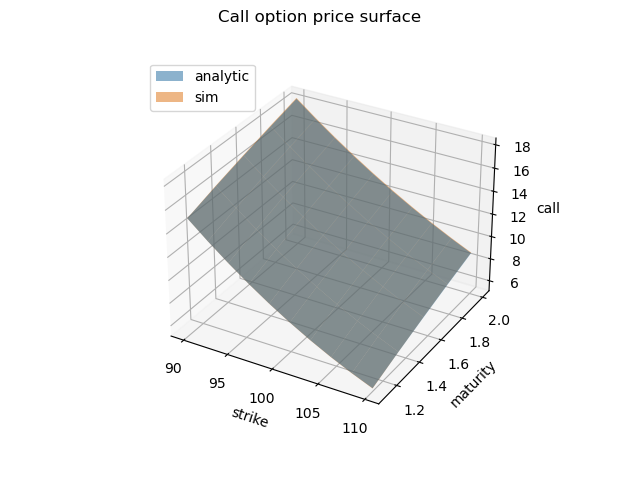

In [9]:
tx, ty = np.meshgrid(bsm.time_grid[1:], bsm.time_grid[1:])
figcall = plt.figure()
figcall.suptitle('Call option price surface')
axcall = plt.axes(projection="3d")
surf = axcall.plot_surface(strikes_, maturities_, call_analytic, label='analytic', alpha=0.5)
surf._facecolors2d = surf._facecolor3d
surf._edgecolors2d = surf._edgecolor3d
surf = axcall.plot_surface(strikes_, maturities_, call_mc, label='sim', alpha=0.5)
surf._facecolors2d = surf._facecolor3d
surf._edgecolors2d = surf._edgecolor3d
axcall.set_xlabel('strike')
axcall.set_ylabel('maturity')
axcall.set_zlabel('call')
axcall.legend(loc='upper left')
plt.show()

<IPython.core.display.Javascript object>


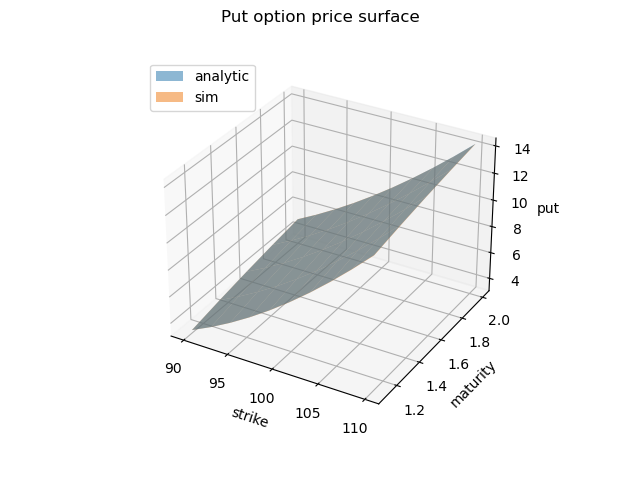

In [10]:
tx, ty = np.meshgrid(bsm.time_grid[1:], bsm.time_grid[1:])
figput = plt.figure()
figput.suptitle('Put option price surface')
axput = plt.axes(projection="3d")
surf = axput.plot_surface(strikes_, maturities_, put_analytic, label='analytic', alpha=0.5)
surf._facecolors2d = surf._facecolor3d
surf._edgecolors2d = surf._edgecolor3d
surf = axput.plot_surface(strikes_, maturities_, put_mc, label='sim', alpha=0.5)
surf._facecolors2d = surf._facecolor3d
surf._edgecolors2d = surf._edgecolor3d
axput.set_xlabel('strike')
axput.set_ylabel('maturity')
axput.set_zlabel('put')
axput.legend(loc='upper left')
plt.show()

## Example: Price & Intrinsic Value

In [11]:
spots = np.linspace(0.1, 120, 20)
strike=95
prices_call = bs.Analytic.fromParamValues(sigma=0.2, r=0.03).price(spots, tau=1, k=strike, pc='c')
prices_put = bs.Analytic.fromParamValues(sigma=0.2, r=0.03).price(spots, tau=1, k=strike, pc='p')

<IPython.core.display.Javascript object>


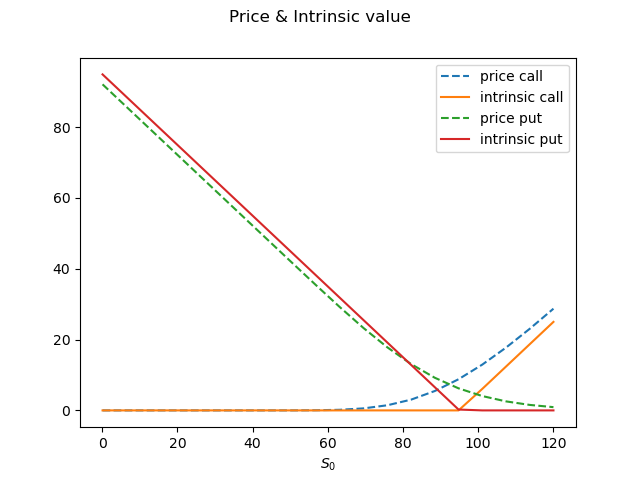

In [12]:
fig_payoff, ax_payoff = plt.subplots()
fig_payoff.suptitle('Price & Intrinsic value')
ax_payoff.plot(spots, prices_call, linestyle='--', label='price call')
ax_payoff.plot(spots, np.maximum(spots-strike,0), label='intrinsic call')
ax_payoff.plot(spots, prices_put, linestyle='--', label='price put')
ax_payoff.plot(spots, np.maximum(strike-spots,0), label='intrinsic put')
ax_payoff.legend()
ax_payoff.set_xlabel('$S_0$')
plt.show()

# Black-Scholes Extensions

## Garman-Kohlhagen FX Model
The Black-Scholes model can also be applied to price options on foreign exchange rates (FX) with minor extensions. This version is called the [Garman-Kohlhagen model](https://en.wikipedia.org/wiki/Foreign_exchange_option#Valuation:_the_Garman%E2%80%93Kohlhagen_model).

**Definition:** Let $(\Omega, \mathcal{F}, \mathbb{P})$ be a probability space, where we think of $\mathbb{P}$ as the real-world measure. Assume that an FX rate $X_t$, a domestic bank account numeraire $B^d_t$ and a foreign bank account numeraire $B^f_t$ follow
\begin{align*}
    dX_t &= \mu X_t + \sigma X_t dW_t, \\
    dB_t^d &= r_d B_t^d dt \\
    dB_t^f &= r_f B_t^f dt
\end{align*}
where 
* $\mu \in \mathbb{R}$ is the drift, 
* $\sigma > 0$ is the FX volatility,
* $r_d \in \mathbb{R}$ is the domestic risk-free interest rate,
* $r_f \in \mathbb{R}$ is the foreign risk-free interest rate.
We assume that the FX rate is quoted as one unit of foreign currency equals $X$ units of domestic currency. The model $(X_t, B_t^d, B_t^f)$ is called *Garman-Kohlhagen model*.

**Lemma:** In risk-neutral measure $\mathbb{Q}$, the $FX$ rate in the Garman-Kohlhagen model follows
\begin{align*}
    dX_t = (r_d - r_f)X_tdt + \sigma X_t dW_t^{\mathbb{Q}}.
\end{align*}

**Proof:** Denote by $\tilde B_t^d := FX_t B_t^f$ the foreign bank account numeraire in domestic currency. Under $\mathbb{Q}$, the discounted value of this asset has to be a martingale and hence have zero drift. Calculating its dynamics using the Ito product rule yields
\begin{align*}
    d(\tilde B_t^d / B_t^d) 
    =d(X_t e^{(r_f - r_d)t})
    = dX_t e^{(r_f - r_d)t} + X_t (r_f - r_d)e^{(r_f - r_d)t} dt
    = (\mu  + r_f - r_d)X_te^{(r_f - r_d)t}dt + \sigma X_t e^{(r_f - r_d)t} dW_t^{\mathbb{Q}}
\end{align*}
This can only be a martingale if
\begin{align*}
    \mu  + r_f - r_d = 0 \Longleftrightarrow \mu = r_d - r_f
\end{align*}
as claimed.

**Theorem:** A Garman-Kolhagen model has the same risk-neutral dynamics as a Black-Scholes model with interest rate $r:=r_d$ and dividend rate $q:=r_f$. All options on the FX rate can be priced with exactly the same formula as for the Black-Scholes.

## Binary Options

Binary options either pay cash-or-nothing or the asset-or-nothing depending on whether or not the underlying is above or below the strike level. They can be priced quite similar to European options.

**Definition (binary options):** The *cash-or-nothing call/put option* with strike $K$ and maturity $T$ have payoffs
\begin{align*}
    C_T^{c,0} 
    =\begin{cases}
        1, & S_T > K,\\
        0, & S_T \leq K
    \end{cases}
    P_T^{c,0} 
    =\begin{cases}
        0, & S_T > K,\\
        1, & S_T \leq K
    \end{cases}
\end{align*}
and the *asset-or-nothing call/put option* with strike $K$ and maturity $T$ have payoffs
\begin{align*}
    P_T^{S,0} 
    =\begin{cases}
        S_T, & S_T > K,\\
        0, & S_T \leq K
    \end{cases}
    P_T^{S,0} 
    =\begin{cases}
        0, & S_T > K,\\
        S_T, & S_T \leq K
    \end{cases}
\end{align*}

**Theorem (binary option valuation):** The binary options have value
\begin{align*}
    C_t^{c,0} &= e^{-r(T-t)} \Phi(d_2) \\
    P_t^{c,0} &= e^{-r(T-t)} \Phi(-d_2) \\
    C_t{S,0} &= e^{-q (T-t)} S_t \Phi(d_1) \\
    P_t^{S,0} &= e^{-q(T-t)} S_t \Phi(-d_1)
\end{align*}

**Proof:** We may assume $t=0$ without loss of generality. Notice that the underlying can be written as
\begin{align*}
    S_T = s_0 \exp( (r-q-\tfrac{1}{2} \sigma^2)T + \sigma W_T) \sim s_0 \exp( (r-q-\tfrac{1}{2} \sigma^2)T + \sigma \sqrt{T} Z)
\end{align*}
for some $Z \sim \mathcal{N}(0,1)$. We have the characterization
\begin{align*}
    C_T^{c,0} != 0 \Longleftrightarrow S_T > K \Longleftrightarrow Z > -d_2
\end{align*}
and therefore
\begin{align*}
    C_0^{c,0}
    &= e^{-rT} \mathbb{E}[C_T^{c,0}]
    = e^{-rT} \mathbb{E}[1_{\{S_T>k\}}C_T^{c,0}]
    =e^{-rT} \int_{-d_2}^{\infty}{1 \phi(z)dz}
    =e^{-rT} \Phi(d_2).
\end{align*}
Analogously,
\begin{align*}
    P_T^{c,0} != 0 \Longleftrightarrow S_T \leq K \Longleftrightarrow Z \leq -d_2
\end{align*}
and thus
\begin{align*}
    P_0^{c,0}
    &= e^{-rT} \mathbb{E}[P_T^{c,0}]
    = e^{-rT} \mathbb{E}[1_{\{S_T \leq k\}}C_T^{c,0}]
    =e^{-rT} \int_{-\infty}^{-d_2}{1 \phi(z)dz}
    =e^{-rT} \Phi(-d_2).
\end{align*}
The asset-or-nothing case is similar, but here the integral becomes
\begin{align*}
    C_0^{S,0}
    &= e^{-rT} \mathbb{E}[1_{\{S_T>k\}}C_T^{S,0}]
    =e^{-rT} \int_{-d_2}^{\infty}{ s_0 \exp( (r-q-\tfrac{1}{2} \sigma^2)T + \sigma \sqrt{T} z) \phi(z)dz} \\
    &=e^{-qT}s_0 \frac{1}{\sqrt{2 \pi}} \int_{-d_2}^{\infty}{ \exp( \tfrac{1}{2} \sigma^2 T + \sigma \sqrt{T} z + \tfrac{1}{2}z^2) dz} \\
    &=e^{-qT}s_0 \frac{1}{\sqrt{2 \pi}} \int_{-d_2}^{\infty}{ \exp( \tfrac{(z-\sigma\sqrt{T})^2}{2} ) dz} \\
    &=e^{-qT}s_0 \frac{1}{\sqrt{2 \pi}} \int_{-d_2-\sigma\sqrt{T}}^{\infty}{ \exp( \tfrac{u^2}{2}) du} \\
    &=e^{-qT}s_0 \Phi(d_1).
\end{align*}
For the put option, the argument is similar, but the integral evaluates to
\begin{align*}
    P_0^{S,0}
    &= e^{-rT} \mathbb{E}[1_{\{S_T>k\}}P_T^{S,0}]
    =e^{-rT} \int_{-\infty}^{-d_2}{ s_0 \exp( (r-q-\tfrac{1}{2} \sigma^2)T + \sigma \sqrt{T} z) \phi(z)dz} \\
    &=e^{-qT}s_0 \frac{1}{\sqrt{2 \pi}} \int_{-\infty}^{-d_2-\sigma\sqrt{T}}{ \exp( \tfrac{u^2}{2}) du} \\
    &=e^{-qT}s_0 \Phi(-d_1).
\end{align*}

# Greeks
The sensitivities of the option price can also be worked out analytically.

In [13]:
greeks_s0 = np.linspace(80, 120, 40)
greeks_sigma = wd.FloatSlider(min=0.01, max=0.2, value=0.02, step=0.01)
greeks_r = wd.FloatSlider(min=0., max=0.1, value=0.03, step=0.001)
greeks_q = wd.FloatSlider(min=0., max=0.1, value=0., step=0.001)
greeks_tau = wd.FloatSlider(min=0.1, max=5, value=1, step=0.1)
greeks_k = wd.FloatSlider(min=80, max=120, value=100, step=1)

## Delta

The Delta is given by
\begin{align}
    \Delta_{\text{Call}} := \frac{\partial C}{\partial S_0} = e^{-q T} \Phi(d_1), &&
    \Delta_{\text{Put}} := \frac{\partial P}{\partial S_0} = e^{-q T} (\Phi(d_1) - 1)
\end{align}

<IPython.core.display.Javascript object>


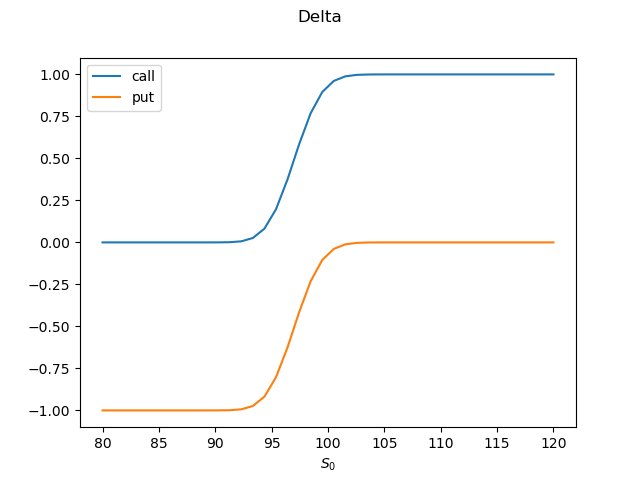

interactive(children=(FloatSlider(value=0.02, description='sigma', max=0.2, min=0.01, step=0.01), FloatSlider(…

In [14]:
fig_delta, ax_delta = plt.subplots()
fig_delta.suptitle('Delta')

@wd.interact(sigma=greeks_sigma, r=greeks_r, q=greeks_q, tau=greeks_tau, k=greeks_k)
def plot_delta(sigma, r, q, tau, k):
    ax_delta.clear()
    a = bs.Analytic.fromParamValues(sigma, r, q)
    ax_delta.plot(greeks_s0, a.delta(greeks_s0, tau, k, 'c'), label='call')
    ax_delta.plot(greeks_s0, a.delta(greeks_s0, tau, k, 'p'), label='put')
    ax_delta.set_xlabel('$S_0$')
    ax_delta.set_ylim([-1.1, 1.1])
    ax_delta.legend()

## Gamma
The gamma is given by
\begin{align}
    \Gamma := \frac{\partial^2 C}{\partial S_0^2} = e^{-q T} \frac{\varphi(d_1)}{\sigma \sqrt{T}} = \frac{\partial^2 P}{\partial S_0^2}
\end{align}

<IPython.core.display.Javascript object>


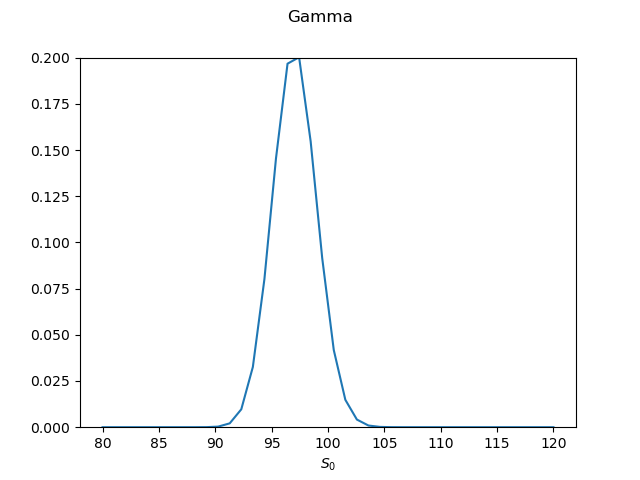

interactive(children=(FloatSlider(value=0.02, description='sigma', max=0.2, min=0.01, step=0.01), FloatSlider(…

In [15]:
fig_gamma, ax_gamma = plt.subplots()
fig_gamma.suptitle('Gamma')

@wd.interact(sigma=greeks_sigma, r=greeks_r, q=greeks_q, tau=greeks_tau, k=greeks_k)
def plot_gamma(sigma, r, q, tau, k):
    ax_gamma.clear()
    a = bs.Analytic.fromParamValues(sigma, r, q)
    ax_gamma.plot(greeks_s0, a.gamma(greeks_s0, tau, k))
    ax_gamma.set_xlabel('$S_0$')
    ax_gamma.set_ylim([0, 0.2])

## Vega
The Vega is given by
\begin{align}
    \mathcal{V} := \frac{\partial C}{\partial \sigma} = e^{-q T} S_0 \varphi(d_1) \sqrt{T} =
    \frac{\partial P}{\partial \sigma}
\end{align}

<IPython.core.display.Javascript object>


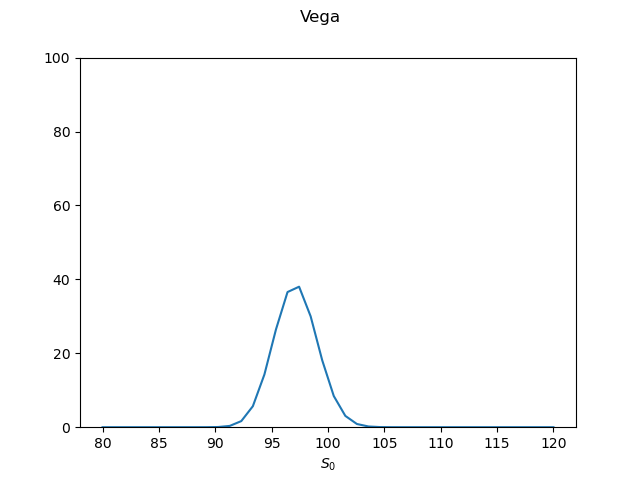

interactive(children=(FloatSlider(value=0.02, description='sigma', max=0.2, min=0.01, step=0.01), FloatSlider(…

In [16]:
fig_vega, ax_vega = plt.subplots()
fig_vega.suptitle('Vega')

@wd.interact(sigma=greeks_sigma, r=greeks_r, q=greeks_q, tau=greeks_tau, k=greeks_k)
def plot_vega(sigma, r, q, tau, k):
    ax_vega.clear()
    a = bs.Analytic.fromParamValues(sigma, r, q)
    ax_vega.plot(greeks_s0, a.vega(greeks_s0, tau, k))
    ax_vega.set_xlabel('$S_0$')
    ax_vega.set_ylim([0, 100])

## Theta
The Theta is given by
\begin{align}
    \Theta_{\text{Call}} &:= 
    \frac{\partial C}{\partial t} 
    = q e^{-q(T-t)}S_0 \Phi(d_1) - r e^{-r(T-t)} K \Phi(d_2) - e^{-q(T-t)}\frac{\sigma S_0 \varphi(d_1)}{2 \sqrt{T-t}}, \\
    \Theta_{\text{Put}} &:= 
    \frac{\partial P}{\partial t}
    = \frac{\partial C}{\partial t} -qe^{-q(T-t)}S_0 + r e^{-r(T-t)} K
\end{align}

<IPython.core.display.Javascript object>


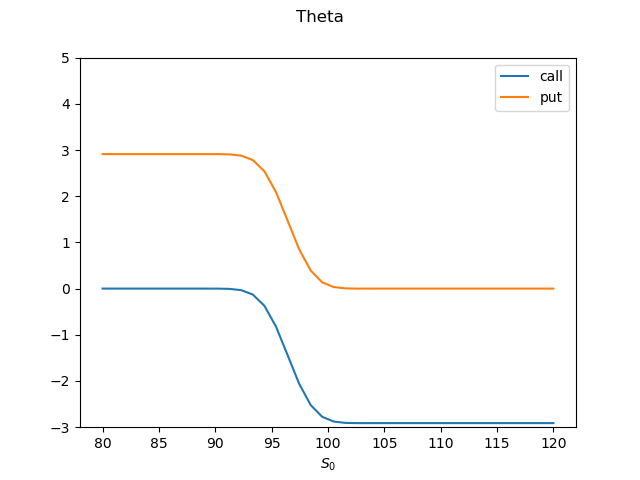

interactive(children=(FloatSlider(value=0.02, description='sigma', max=0.2, min=0.01, step=0.01), FloatSlider(…

In [17]:
fig_theta, ax_theta = plt.subplots()
fig_theta.suptitle('Theta')

@wd.interact(sigma=greeks_sigma, r=greeks_r, q=greeks_q, tau=greeks_tau, k=greeks_k)
def plot_theta(sigma, r, q, tau, k):
    ax_theta.clear()
    a = bs.Analytic.fromParamValues(sigma, r, q)
    ax_theta.plot(greeks_s0, a.theta(greeks_s0, tau, k, 'c'), label='call')
    ax_theta.plot(greeks_s0, a.theta(greeks_s0, tau, k, 'p'), label='put')
    ax_theta.set_xlabel('$S_0$')
    ax_theta.set_ylim([-3, 5])
    ax_theta.legend()

## Rho
The Rho is given by
\begin{align}
    \rho_{\text{Call}} := \frac{\partial C}{\partial r} = T e^{-r T} K \Phi(d_2), &&
    \rho_{\text{Put}} := \frac{\partial P}{\partial r}  &=-T e^{-r T} K \Phi(-d_2)
\end{align}

<IPython.core.display.Javascript object>


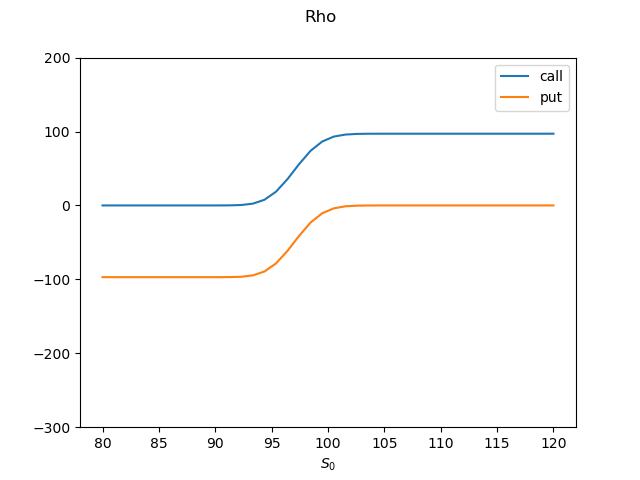

interactive(children=(FloatSlider(value=0.02, description='sigma', max=0.2, min=0.01, step=0.01), FloatSlider(…

In [18]:
fig_rho, ax_rho = plt.subplots()
fig_rho.suptitle('Rho')

@wd.interact(sigma=greeks_sigma, r=greeks_r, q=greeks_q, tau=greeks_tau, k=greeks_k)
def plot_theta(sigma, r, q, tau, k):
    ax_rho.clear()
    a = bs.Analytic.fromParamValues(sigma, r, q)
    ax_rho.plot(greeks_s0, a.rho(greeks_s0, tau, k, 'c'), label='call')
    ax_rho.plot(greeks_s0, a.rho(greeks_s0, tau, k, 'p'), label='put')
    ax_rho.set_xlabel('$S_0$')
    ax_rho.set_ylim([-300, 200])
    ax_rho.legend()

# Black-Scholes PDE

**Lemma:** Let $v:\mathbb{R} \times \mathbb{R}_+ \to \mathbb{R}$, $(s,t) \mapsto v(s,t)$, be a $\mathcal{C}^2$ function and $V_t := v(S_t,t)$. Then
\begin{align}
    \label{EqBSPDEdv}
    dV_t = \Big(r S_t \frac{\partial V}{\partial s} + \frac{1}{2}  \sigma^2 S_t^2 \frac{\partial^2 V}{\partial s^2}  + \frac{\partial V}{\partial t} \Big)dt + \frac{\partial V}{\partial s} \sigma S_t dW_t
\end{align}

**Theorem:** Let $V_t=v(S_t,t)$ be the stochastic process of a European option (call or put) in the Black-Scholes model. Then
\begin{align*}
    r S_t \frac{\partial V}{\partial s} + \frac{1}{2}  \sigma^2 S_t^2 \frac{\partial^2 V}{\partial s^2}  + \frac{\partial V}{\partial t} = rV
\end{align*}

**Proof:** This follows from the Lemma and the fact that $e^{-rt}V_t$ has to be a martingale, hence this process has zero drift.

Thus, one can alternatively compute option prices in the Black-Scholes model using PDE methods.

# Hedging

Assuming we have shorted a European option and we want to hedge this position by trading only in the underlying stock and the bank account numeraire using a self-financing trading strategy. The evolution of such a portfolio is given by the following.

**Theorem:** Let $\phi=(u, \beta)$ be a self-financing trading strategy in $(S_t, B_t)$ in the Black-Scholes model and $\Pi := u S + \beta B$ be the associated portfolio. Then
\begin{align*}
    d\Pi_t = r \Pi_t dt + u_t \sigma S_t dW_t
\end{align*}
Setting
\begin{align*}
    u_t := u_t,
\end{align*}
the the total portfolio $P := -V + \Pi$ of shorting the option and going long the replication portfolio satisfies
\begin{align*}
    P_t = P_0 e^{r t}.
\end{align*}
In particular, $P_t$ is deterministic.

**Proof:**
For the first equation, we use the self-financing condition to obtain
\begin{align*}
    d\Pi_t
    &= u_t dS_t + \beta_t dB_t \\
    &= u_t (rS_t dt + \sigma S_t dW_t) + r \beta_t B_t dt \\
    &= u_t (rS_t dt + \sigma S_t dW_t) + r (\Pi_t - u_t S_t) dt\\
    &= u_t \sigma S_t dW_t  + r \Pi_t dt
\end{align*}
Using the Black-Scholes PDE we calculate
\begin{align*}
    dP = -dV + d\Pi
    &=-\Big(r S_t \frac{\partial V}{\partial x} + \frac{1}{2}  \sigma^2 S_t^2 \frac{\partial^2 V}{\partial x^2}  + \frac{\partial V}{\partial t} \Big)dt - \frac{\partial V}{\partial x} \sigma S_t dW_t +  r \Pi_t dt + u_t \sigma S_t dW_t \\
    &=-\Big(r S_t \frac{\partial V}{\partial x} + rV_t - rS_t \frac{\partial V}{\partial x} \Big)dt  +  r \Pi_t dt \\
    &=r( \Pi_t - V_t)dt = r P_t dt,
\end{align*}
which solves to $P_t = P_0 e^{r t}$. 

To apply this in practice, we have to use a discrete hedging approach though: Let $0=t_0 < \ldots < t_m = T$ be a discretization of the interval [0, T]. For any $0 \leq n \leq m$, we denote the portfolio quantities at $t_n$ by
\begin{align*}
    \Pi_n = u_n S_n + b_n,
\end{align*}
where $b_n := \beta_n B_n$. Let $V$ be a European option maturing at $T$. Then the *Delta-Hedge* of $V$ on this grid is defined by setting
\begin{align*}
    u_n := \Delta_n := \frac{\partial V}{\partial S_{t_n}}.
\end{align*}
Notice that due to the self-financing condition in discrete time,
\begin{align*}
    \Pi_{n+1} - \Pi_n = \Delta_n(S_{n+1}-S_n) + b_{n+1}-b_n,
\end{align*}
this completely determines the hedge strategy. In more detail, we use the following.

**Definition (Delta hedge):** The self-financing trading strategy $\phi=(u^+, b^+)$ recursively defined as follows is called *Delta hedge*: We denote by $u_n^-,\beta_n^-$ the fraction of stock and cash at $t_n$ before rebalancing and by $u_n^-, \beta_n^-$ after rebalancing. At $n=0$, we have only collected the option premium $V_0$, i.e.
\begin{align*}
    u^-_0 := 0, && b_0^- := V_0, 
\end{align*}
To implement the Delta hedge, we now rebalance the portfolio to
\begin{align*}
    u_0^+ := \Delta_0, && b_0^+ := V_0 - \Delta_0 S_0
\end{align*}
Now, after each passing time period of length $\tau_n := t_{n+1}-t_n$ from $n \to n+1$ the positions are
\begin{align*}
    u_{n+1}^- = \Delta_n, && b_{n+1}^- = e^{r \tau_n} b_n^+.
\end{align*}
To update the Delta hedge, we have to rebalance via
\begin{align*}
    u_{n+1}^+ := \Delta_{n+1}, && b_{n+1}^+ := \Delta_n S_{n+1} - \Delta_{n+1}S_{n+1}+b_{n+1}^-
\end{align*}
The quantity
\begin{align*}
    \operatorname{PnL} := b_{m}^+ + \Delta_m S_m - V_T,
\end{align*}
where $V_T$ is the payoff of the option, is called *Hedge PnL*.

**Lemma:** The Hedge PnL is given by
\begin{align*}
    \operatorname{PnL} = e^{rT}V_0 - V_T + \sum_{n=0}^{m-1}{ e^{r(T-t_n)} \Delta_n (S_{n+1} - e^{r \tau_n} S_n)}
\end{align*}

In [19]:
params = bs.Params(sigma=0.2, r=0., q=0.)

maturity = 1
ntimes = maturity * 365
time_grid = np.linspace(0, maturity, ntimes)
npaths = 100000

bsm = bs.Simulation(params, time_grid, npaths)
bsm.simulate(s0=100)

strike = 100

In [20]:
def calc_hedge(bsm, strike, days=1):
    s0 = bsm.s_[:, 0].mean()
    maturity = bsm.time_grid[-1]
    v0 = bsm.analytic.price(s0, maturity, strike, 'c').mean()
    hedge_grid = bsm.time_grid[::days] 
    taus = hedge_grid[1:] - hedge_grid[:-1]
    s = bsm.s_[:, ::days]
    stock_returns = s[:, 1:] - s[:, :-1] * np.exp(bsm.params.r * taus)
    deltas = np.array([bsm.analytic.delta(s[:, n], maturity - hedge_grid[n], strike, 'c') for n in range(hedge_grid.shape[0]-1)]).T
    pnl = np.sum(deltas * stock_returns * np.exp(bsm.params.r * (maturity - hedge_grid[1:])), axis=1)
    payoff = np.maximum(bsm.s_[:, -1]-strike, 0)
    return pnl - payoff + np.exp(bsm.params.r * maturity) * v0

In [21]:
days_range = [1, 5, 30]
pnls = [calc_hedge(bsm, strike, d) for d in days_range]

<IPython.core.display.Javascript object>


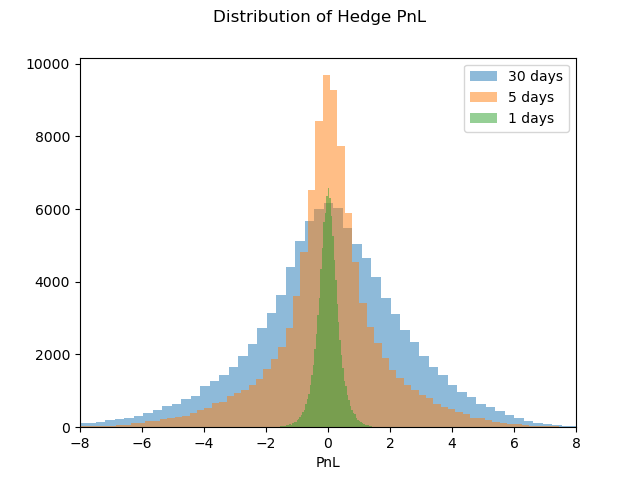

In [22]:
fig_hedge, ax_hedge = plt.subplots()
fig_hedge.suptitle('Distribution of Hedge PnL')
for day, pnl in list(reversed(list(zip(days_range, pnls)))):
    ax_hedge.hist(pnl, bins=100, label='%i days' % day, alpha=0.5)
ax_hedge.set_xlabel('PnL')
ax_hedge.set_xlim([-8, 8])
ax_hedge.legend()
plt.show()